# 1. Import der benötigten Packete und des Datenbezugs

In [2]:
import FINE as fn

import pandas as pd
import numpy as np


## Pakete zur Visualisierung

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Import Funktion getData

In [4]:
from getData_H1_2023_NP import get_data

In [5]:
data, profile = get_data()

      Connection Car to Wallbox 
0                              1
1                              1
2                              1
3                              1
4                              1
...                          ...
8755                           1
8756                           1
8757                           1
8758                           1
8759                           1

[8760 rows x 1 columns]


# 2. Erstellen der Energy Model Instanzen

In [6]:
# H1 = Haushalt
# electricity = Strom
# ev_electricity = Strom der in das E-Atuo gespeißt wird oder aus der Fahrzeugbatterie bei V2G entnommen wird
# pv_electricity = Strom der von der Solaranlage erzeugt wird
# SG = Saubere Geschirr
# SW = Schmutzige Wäsche
# SWN = Saubere Wäsche Nass
# SWT = Saubere Wäsche Trocken 


In [7]:
esM = fn.EnergySystemModel(
    locations={"H1"},
    commodities={"electricity","pv_electricity", "ev_electricity", "geschirr", "nasse_waesche", "trockene_waesche", "schmutzige_waesche", "waesche_fuer_trockner"}, 
    commodityUnitsDict={"electricity": r"KW$_{el}$", 
                        "ev_electricity": r"KW$_{el}$",
                        "pv_electricity": r"KW$_{el}$",
                        "geschirr": r"SG",
                        "schmutzige_waesche": r"SW",
                        "nasse_waesche": r"SWN",
                        "waesche_fuer_trockner": r"WFT",
                        "trockene_waesche":r"SWT"},
    numberOfTimeSteps=8760,
    hoursPerTimeStep=1,
    costUnit="1 Euro",
    lengthUnit="m",
    verboseLogLevel=0,
)

# 3. Quellen

## PV-Erzeugung

In [8]:
esM.add(
    fn.Source(
        esM = esM,
        name = "Photovoltaik",
        commodity="pv_electricity",
        hasCapacityVariable=False,
        operationRateFix=data["pv_source"],
        commodityCost = 0
    )
 )

In [9]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="pv_conversion",
        physicalUnit=r"KW$_{el}$",
        commodityConversionFactors={"pv_electricity": -1, "electricity": 1}
    )
)

## Strombezug

In [10]:
esM.add(
     fn.Source(
        esM = esM,
        name = "Strombezug",
        commodity="electricity",
        hasCapacityVariable=False,
        commodityCost = 0.3798 #--> Fixer Tarif
    )
)

# 4. Intelligent BEV-Charging

In [11]:
rate = [(int(x)*11) for x in profile[0]["Connection Car to Wallbox "]]
esM.add(
    fn.Conversion(
        esM=esM,
        name="ev_charging" ,
        physicalUnit=r"KW$_{el}$",
        commodityConversionFactors={"electricity": -1, "ev_electricity": 0.95}, 
        hasCapacityVariable=False,
        operationRateMax= pd.DataFrame({"H1": rate})
    )
)

In [12]:
rate = [(int(x)*11) for x in profile[0]["Connection Car to Wallbox "]]  
esM.add(
    fn.Conversion(
        esM=esM,
        name="ev_discharging",
        physicalUnit=r"KW$_{el}$",
        commodityConversionFactors={"electricity": 0.95, "ev_electricity": -1}, 
        hasCapacityVariable=False,
        operationRateMax= pd.DataFrame({"H1": rate})
    )
)

### V2G Speicher

In [13]:
esM.add(
    fn.Storage(
        esM=esM,
        name="ev_batterie",
        commodity="ev_electricity",
        hasCapacityVariable=True,
        capacityMax=60, 
        stateOfChargeMin=0.2,
        chargeEfficiency=1,
        dischargeEfficiency=1,
        selfDischarge=0.001,
        chargeRate=0.1833,
        dischargeRate=0.1833
    )
)

### Mobilitätsbedarf

In [14]:
esM.add(
    fn.Sink(
        esM=esM,
        name="mobility_demand",
        commodity="ev_electricity",
        hasCapacityVariable=False,
        operationRateFix=data["H1_Mobility"]["Mobility Demand flex"]
    )
)

# 4. Speicher

## Batteriespeicher

In [15]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Battery Storage",
        commodity="electricity",
        chargeEfficiency=0.95,
        dischargeEfficiency=0.95,
        chargeRate=0.5,
        dischargeRate=0.5,
        capacityMax=7.5,
    )
) 

# 5. Senken / Grundbedarf

## Haushalt H1

### Baseload

In [16]:
esM.add(
    fn.Sink(
        esM=esM,
        name="H1_Baseload",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=data["H1_Baseload"]["H1_fix_V2G"]
    )
)

### Stromverkauf

In [17]:
 esM.add(
    fn.Sink(
        esM = esM,
        name = "Export",
        commodity="pv_electricity",
        hasCapacityVariable=False,
        commodityRevenue = 0.08 # für fixe Vergütung 
    )
)

# 6. Optimierung 

In [18]:
# esM.aggregateTemporally(numberOfTypicalPeriods=7)

In [19]:
esM.optimize(timeSeriesAggregation=False, solver="gurobi")

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8713 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5126 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.4464 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.7584 sec)

		(0.0000 sec)

Declaring objective function...
		(7.6751 sec)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Read LP format model from file C:\Users\fl5004\AppData\Local\Temp\tmp6lf9pvcd.pyomo.lp
Reading time = 0.27 seconds
x1: 122653 rows, 122654 columns, 350426 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value

C:\Users\fl5004\miniforge3\envs\fine\lib\site-packages\FINE\storage.py:1969: UserWarning: Charge and discharge at the same time for component ev_batterie
  warnings.warn(


for StorageModel ...  (1.4103sec)
		(6.8717 sec)



# 7. Ergebnisse

In [20]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

H1
Component       Property        Unit                        
Export          NPVcontribution [1 Euro]          -405.70058
                TAC             [1 Euro/a]        -405.70058
                commodRevenues  [1 Euro/a]         405.70058
                operation       [KW$_{el}$*h/a]  5071.257244
                                [KW$_{el}$*h]    5071.257244
H1_Baseload     operation       [KW$_{el}$*h/a]      3033.47
                                [KW$_{el}$*h]        3033.47
Photovoltaik    operation       [KW$_{el}$*h/a]  9530.716489
                                [KW$_{el}$*h]    9530.716489
Strombezug      NPVcontribution [1 Euro]           408.77543
                TAC             [1 Euro/a]         408.77543
                commodCosts     [1 Euro/a]         408.77543
                operation       [KW$_{el}$*h/a]  1076.291285
                                [KW$_{el}$*h]    1076.291285
mobility_demand operation       [KW$_{el}$*h/a]       2109.7
                                [KW$_{el}$*h]         2109.7

In [21]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

H1
Component      Property      Unit                        
ev_charging    operation     [KW$_{el}$*h/a]  2351.102046
                             [KW$_{el}$*h]    2351.102046
ev_discharging operation     [KW$_{el}$*h/a]    36.284393
                             [KW$_{el}$*h]      36.284393
pv_conversion  capacity      [KW$_{el}$]             6.34
               commissioning [KW$_{el}$]             6.34
               operation     [KW$_{el}$*h/a]  4459.459245
                             [KW$_{el}$*h]    4459.459245

In [22]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

H1
Component       Property           Unit                         
Battery Storage capacity           [KW$_{el}$*h]             7.5
                commissioning      [KW$_{el}$*h]             7.5
                operationCharge    [KW$_{el}$*h/a]   1904.088783
                                   [KW$_{el}$*h]     1904.088783
                operationDischarge [KW$_{el}$*h/a]   1718.440127
                                   [KW$_{el}$*h]     1718.440127
ev_batterie     capacity           [KW$_{el}$*h]       31.533006
                commissioning      [KW$_{el}$*h]       31.533006
                operationCharge    [KW$_{el}$*h/a]  35710.472174
                                   [KW$_{el}$*h]    35710.472174
                operationDischarge [KW$_{el}$*h/a]  35622.909623
                                   [KW$_{el}$*h]    35622.909623

In [44]:
fn.standardIO.writeOptimizationOutputToExcel(esM, outputFileName = "H1 only V2H 2023") 
results_source_sink = pd.read_excel("H1 only V2H 2023.xlsx", sheet_name = "SourceSink_TDoptVar_1dim")
results_conversion = pd.read_excel("H1 only V2H 2023.xlsx", sheet_name = "Conversion_TDoptVar_1dim")
results_storage = pd.read_excel("H1 only V2H 2023.xlsx", sheet_name = "Storage_TDoptVar_1dim")


Writing output to Excel... 
	Processing SourceSinkModel ...
	Processing ConversionModel ...
	Processing StorageModel ...
	Saving file...
Done. (5.5556 sec)


In [24]:
# Unnötige Zeilen/Spalten entfernen um reine Zeitreihendaten für Quellen/Senken zu erhalten.
# Für SourceSink
source_sink_df = results_source_sink.drop(["Variable", "Location"], axis=1).T
source_sink_df = source_sink_df.reset_index()
source_sink_df.columns = source_sink_df.iloc[0]
source_sink_df = source_sink_df.iloc[1:]

In [25]:
# Für Conversion 
conversion_df = results_conversion.drop(["Variable", "Location"], axis=1).T
conversion_df = conversion_df.reset_index()
conversion_df.columns = conversion_df.iloc[0]
conversion_df = conversion_df.reset_index()
conversion_df = conversion_df.iloc[1:]

In [26]:
results_storage

Variable        Component Location         0  \
0         chargeOperationVariablesOptimum  Battery Storage       H1  0.000000   
1                                     NaN      ev_batterie       H1  5.780000   
2      dischargeOperationVariablesOptimum  Battery Storage       H1  0.000000   
3                                     NaN      ev_batterie       H1  5.773693   
4  stateOfChargeOperationVariablesOptimum  Battery Storage       H1  4.510917   
5                                     NaN      ev_batterie       H1  6.306601   

          1         2         3         4         5         6  ...      8750  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
1  5.780000  5.780000  5.780000  5.780000  5.780000  5.780000  ...  0.000000   
2  0.000000  0.086639  0.000000  0.000000  0.086639  0.000000  ...  0.000000   
3  5.773693  5.773693  5.773693  5.773693  5.773693  5.705621  ...  0.000000   
4  4.510917  4.510917  4.419718  4.419718  4.419718  4.328520  ...  5.791423   
5  6.306601  6.306601  6.306601  6.306601  6.306601  6.306601  ...  6.312914   

       8751      8752      8753      8754      8755      8756      8757  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  5.780000  5.780000  5.780000  5.780000  5.780000  5.780000  5.780000   
2  0.076566  0.000000  0.000000  0.000000  0.866639  0.000000  0.186639   
3  5.773693  5.773693  5.773693  5.773693  5.773693  5.773693  5.773693   
4  5.791423  5.710828  5.710828  5.710828  5.710828  4.798577  4.798577   
5  6.306601  6.306601  6.306601  6.306601  6.306601  6.306601  6.306601   

       8758      8759  
0  0.000000  0.000000  
1  5.780000  5.780000  
2  0.000000  0.086639  
3  5.773693  5.773693  
4  4.602115  4.602115  
5  6.306601  6.306601  

[6 rows x 8763 columns]

In [27]:
results_storage["Variable"] = results_storage["Variable"].ffill()
results_storage["Component"] = results_storage["Variable"] + "-" + results_storage["Component"]
storage_df = results_storage.drop(["Variable", "Location"], axis=1).T
storage_df = storage_df.reset_index()
storage_df.columns = storage_df.iloc[0]
storage_df = storage_df.iloc[1:]

In [28]:
storage_df

0    Component chargeOperationVariablesOptimum-Battery Storage  \
1            0                                             0.0   
2            1                                             0.0   
3            2                                             0.0   
4            3                                             0.0   
5            4                                             0.0   
...        ...                                             ...   
8756      8755                                             0.0   
8757      8756                                             0.0   
8758      8757                                             0.0   
8759      8758                                             0.0   
8760      8759                                             0.0   

0    chargeOperationVariablesOptimum-ev_batterie  \
1                                           5.78   
2                                           5.78   
3                                           5.78   
4                                           5.78   
5                                           5.78   
...                                          ...   
8756                                        5.78   
8757                                        5.78   
8758                                        5.78   
8759                                        5.78   
8760                                        5.78   

0    dischargeOperationVariablesOptimum-Battery Storage  \
1                                                   0.0   
2                                                   0.0   
3                                              0.086639   
4                                                   0.0   
5                                                   0.0   
...                                                 ...   
8756                                           0.866639   
8757                                                0.0   
8758                                           0.186639   
8759                                                0.0   
8760                                           0.086639   

0    dischargeOperationVariablesOptimum-ev_batterie  \
1                                          5.773693   
2                                          5.773693   
3                                          5.773693   
4                                          5.773693   
5                                          5.773693   
...                                             ...   
8756                                       5.773693   
8757                                       5.773693   
8758                                       5.773693   
8759                                       5.773693   
8760                                       5.773693   

0    stateOfChargeOperationVariablesOptimum-Battery Storage  \
1                                              4.510917       
2                                              4.510917       
3                                              4.510917       
4                                              4.419718       
5                                              4.419718       
...                                                 ...       
8756                                           5.710828       
8757                                           4.798577       
8758                                           4.798577       
8759                                           4.602115       
8760                                           4.602115       

0    stateOfChargeOperationVariablesOptimum-ev_batterie  
1                                              6.306601  
2                                              6.306601  
3                                              6.306601  
4                                              6.306601  
5                                              6.306601  
...                                                 ...  
8756                                           6.

In [29]:
beginning = 4000
ending = 4336

source_sink_selection = source_sink_df.iloc[beginning:ending]
conversion_selection = conversion_df.iloc[beginning:ending]
storage_selection = storage_df.iloc[beginning:ending]

In [30]:
storage_selection["chargeOperationVariablesOptimum-Battery Storage"]

4001         0.0
4002         0.0
4003         0.0
4004         0.0
4005         0.0
          ...   
4332         0.0
4333         0.0
4334         0.0
4335         0.0
4336    1.113715
Name: chargeOperationVariablesOptimum-Battery Storage, Length: 336, dtype: object

In [31]:
 #  data
x = np.arange(beginning, ending)
y1 = np.array(source_sink_selection["Photovoltaik"].tolist())

charging = np.array(conversion_selection["ev_charging"].tolist())+np.array(storage_selection["chargeOperationVariablesOptimum-Battery Storage"].tolist())
discharging = np.array(conversion_selection["ev_discharging"].tolist())+np.array(storage_selection["dischargeOperationVariablesOptimum-Battery Storage"].tolist())

demand1 = np.array(source_sink_selection["H1_Baseload"].tolist()) + charging
demand = np.array(demand1) - discharging
line_data = np.array(demand)
plt.figure(figsize=(30, 10))

# Create stacked area chart
plt.stackplot(x, y1, labels=["Solar"], 
              colors = ["khaki"], alpha=0.8)

# Add a line to the chart
plt.plot(x, line_data, label='Demand', color='black', alpha=0.8)

# Add legend
plt.legend(loc='upper left')

# Add labels and title
plt.xlabel('timesteps')
plt.ylabel('kW/h')
plt.title('Stacked Area Chart with Line')


# Show the plot
plt.savefig("V2GVisualisierung")
plt.show()

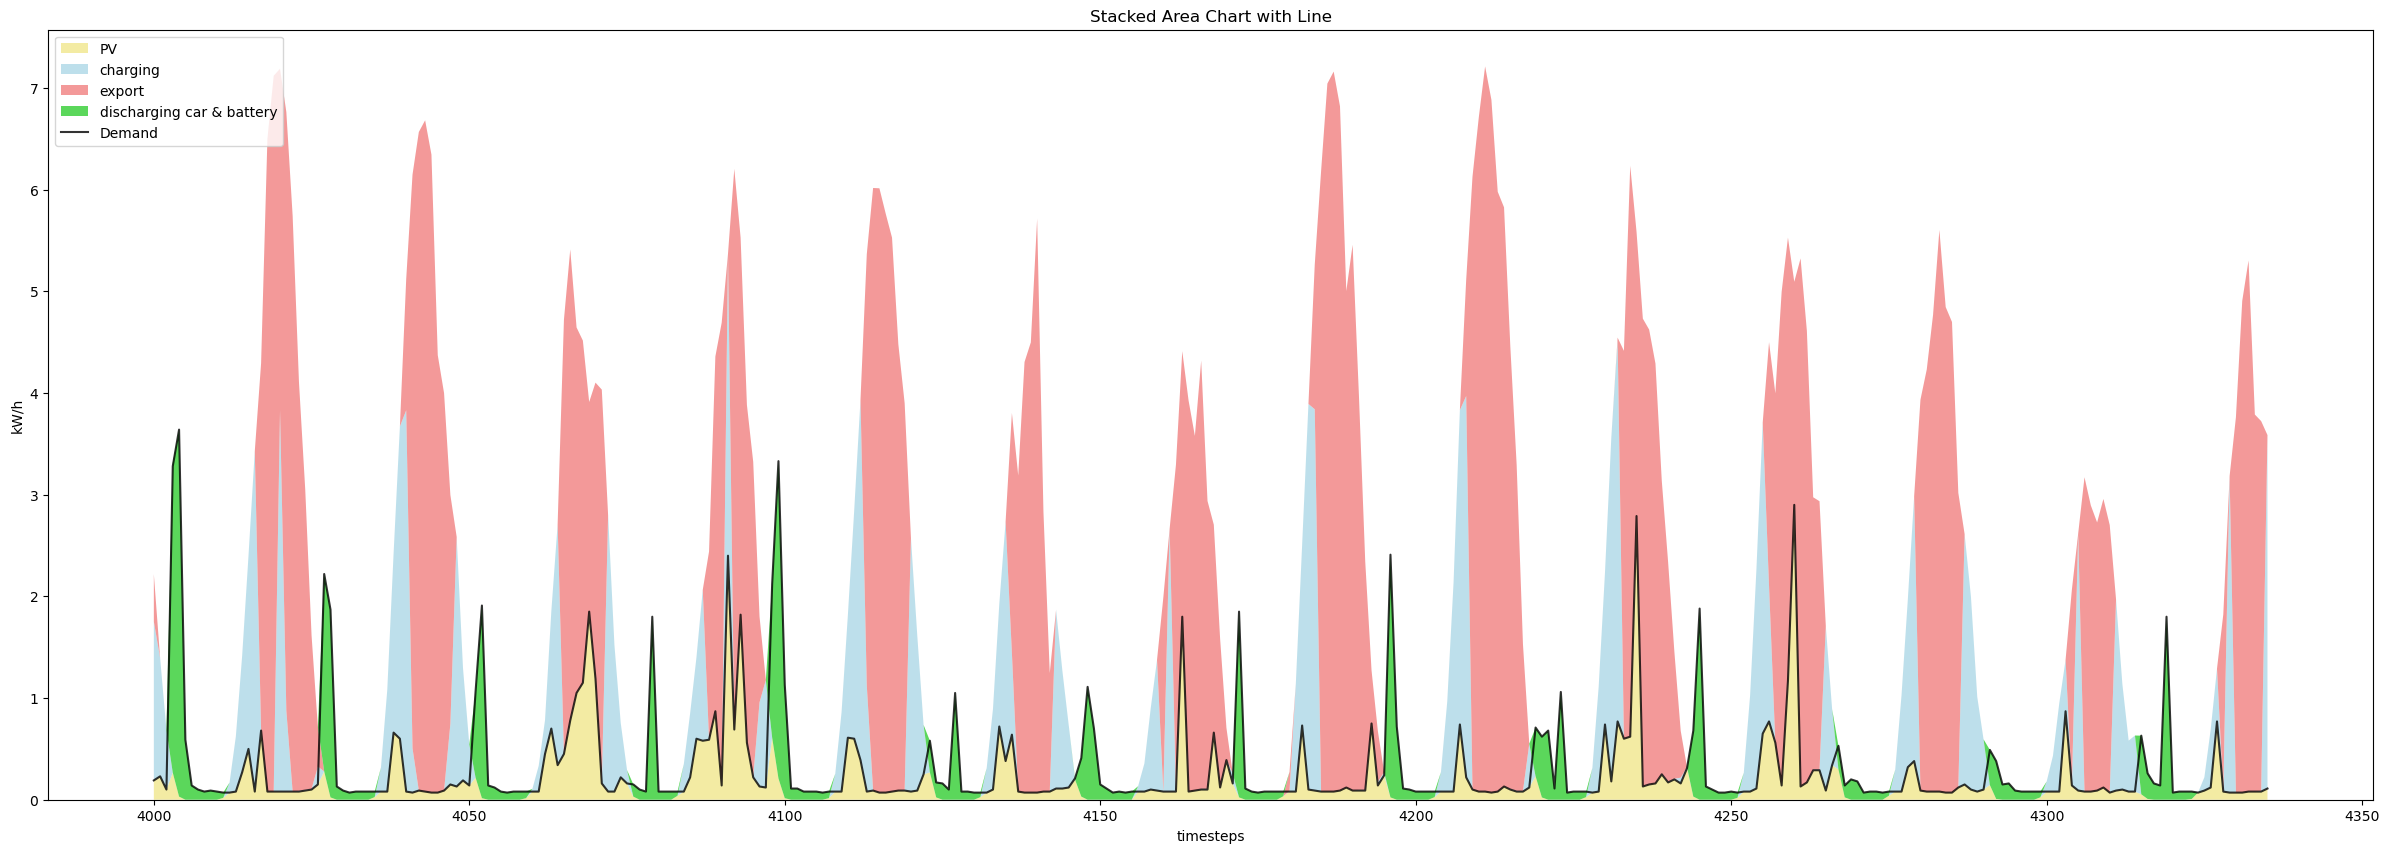

In [48]:
 #  data
charging = np.array(conversion_selection["ev_charging"].tolist())+np.array(storage_selection["chargeOperationVariablesOptimum-Battery Storage"].tolist())
discharging = np.array(conversion_selection["ev_discharging"].tolist())+np.array(storage_selection["dischargeOperationVariablesOptimum-Battery Storage"].tolist())


demand = np.array(source_sink_selection["H1_Baseload"].tolist())
x = np.arange(beginning, ending)
PV = np.array(source_sink_selection["Photovoltaik"].tolist())
y1 = np.minimum(demand, PV)
y2 = np.maximum((PV - demand), 0) - charging
y3 = charging
y4 = discharging

line_data = np.array(demand)
plt.figure(figsize=(30, 10))


# Create stacked area chart
plt.stackplot(x, y1, y3, y2, y4, labels=["PV", "charging", "export", "discharging car & battery"], 
              colors = ["khaki", "lightblue", "lightcoral", "limegreen"], alpha=0.8)

# Add a line to the chart
plt.plot(x, line_data, label='Demand', color='black', alpha=0.8)
#plt.plot(x, np.array(), label='Demand', color='orange', alpha=0.8)

# Add legend
plt.legend(loc='upper left')

# Add labels and title
plt.xlabel('timesteps')
plt.ylabel('kW/h')
plt.title('Stacked Area Chart with Line')


# Show the plot
plt.savefig("V2GVisualisierung H1 only V2H 2023")
plt.show()

## Visualisierung der Komponenten

In [33]:
 fig, ax = fn.plotOperationColorMap(esM, "Photovoltaik", "H1")

In [34]:
fig, ax = fn.plotOperationColorMap(esM, "H1_Baseload", "H1")

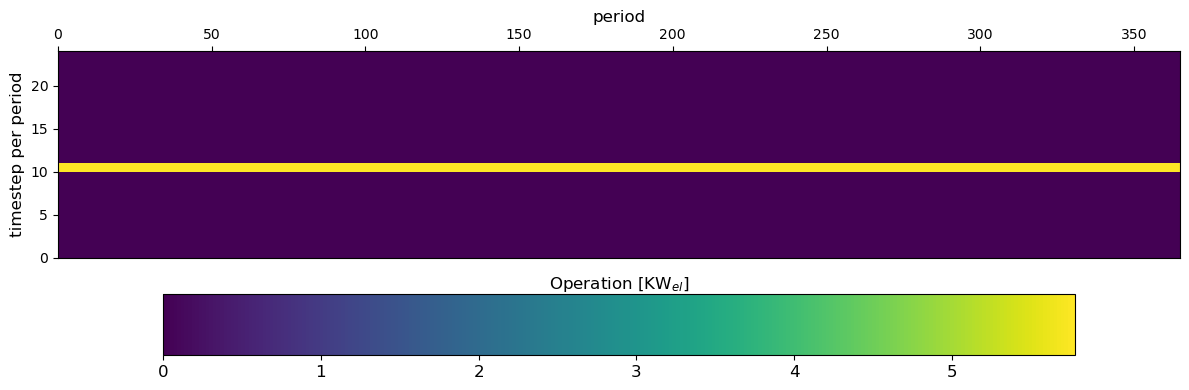

In [35]:
fig, ax = fn.plotOperationColorMap(esM, "mobility_demand", "H1") # Demand immer auf 10 gesetzt hier daher durchgehender Balken 

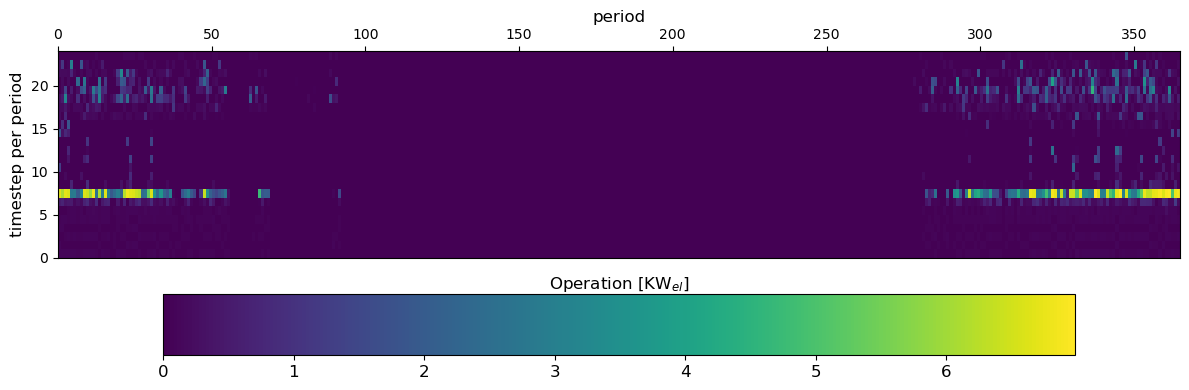

In [45]:
fig, ax = fn.plotOperationColorMap(esM, "Strombezug", "H1")
fig.savefig("Import H1 only V2H 2023")

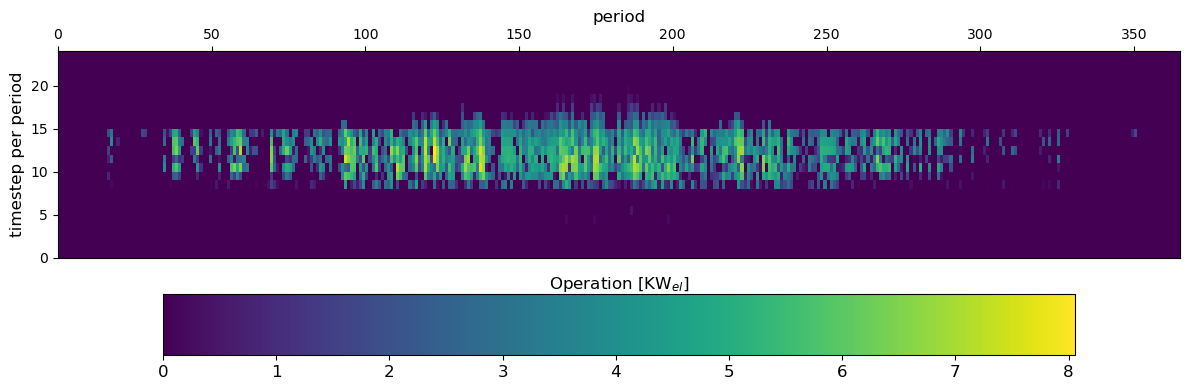

In [47]:
fig, ax = fn.plotOperationColorMap(esM, "Export", "H1")
fig.savefig("Export H1 only V2H 2023")

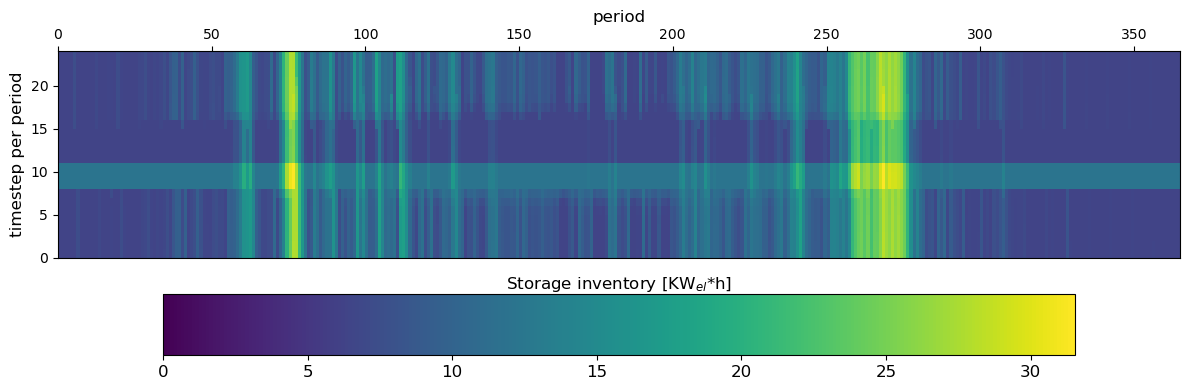

In [38]:
fig, ax = fn.plotOperationColorMap(esM, "ev_batterie", "H1", variableName="stateOfChargeOperationVariablesOptimum")

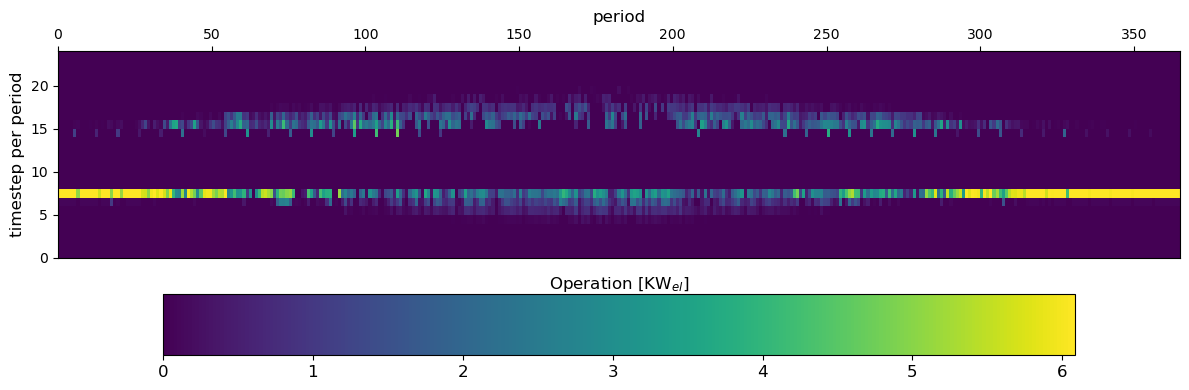

In [39]:
 fig, ax = fn.plotOperationColorMap(esM, "ev_charging", "H1")

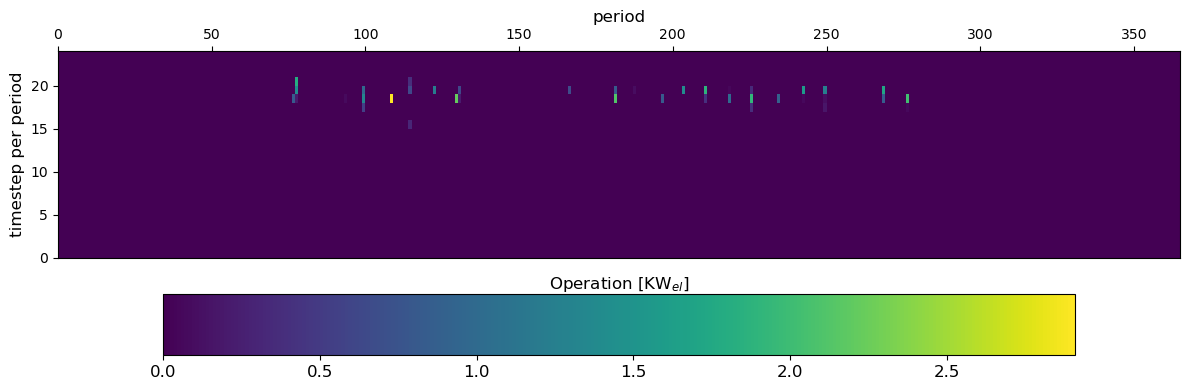

In [40]:
fig, ax = fn.plotOperationColorMap(esM, "ev_discharging", "H1")

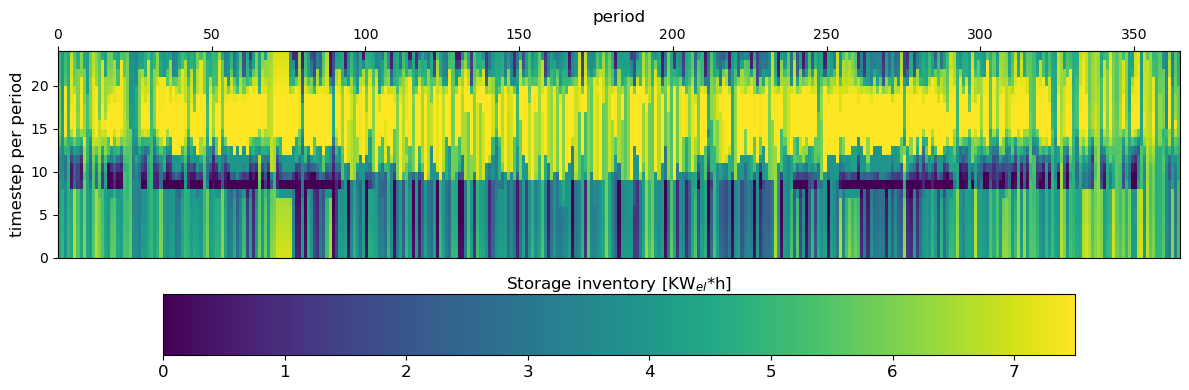

In [41]:
fig, ax = fn.plotOperationColorMap(esM, "Battery Storage", "H1", variableName="stateOfChargeOperationVariablesOptimum")

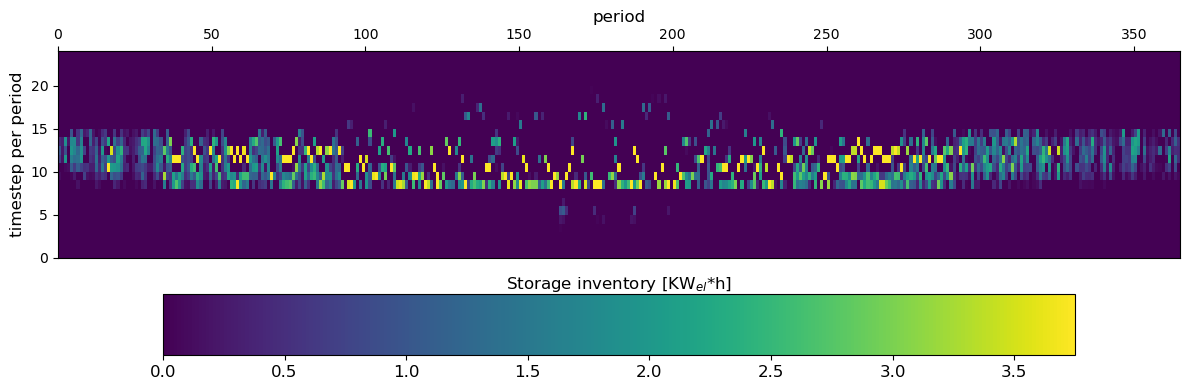

In [42]:
fig, ax = fn.plotOperationColorMap(esM, "Battery Storage", "H1", variableName="chargeOperationVariablesOptimum")

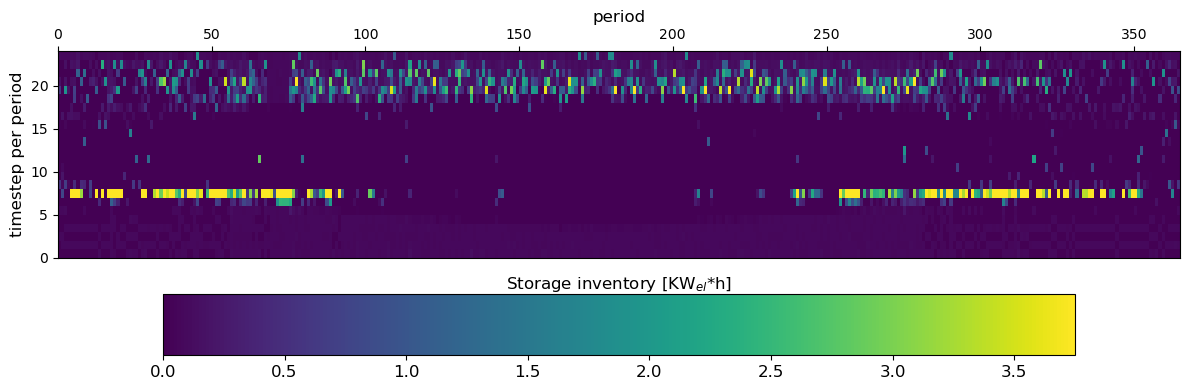

In [43]:
fig, ax = fn.plotOperationColorMap(esM, "Battery Storage", "H1", variableName="dischargeOperationVariablesOptimum")